In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Carrega o dataset como dataframe
df = pd.read_csv('dataset/video_games_2016.csv')

In [3]:
# Remove outliers
Q1 = df['Global_Sales'].quantile(0.00)
Q3 = df['Global_Sales'].quantile(0.98)

df = df[(df['Global_Sales'] >= Q1 ) & (df['Global_Sales'] <= Q3 )]

In [4]:
# Cria coluna com a região que mais vendeu
column_to_number = {
    'NA_Sales':    "NA",
    'EU_Sales':    "EU",
    'JP_Sales':    "JP",
    'Other_Sales': "Outro" 
}

df['Greatest'] = df[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']].idxmax(axis=1).map(column_to_number)

In [5]:
print ( df["Critic_Score"].isna().sum() )
print ( df["Critic_Count"].isna().sum() )

8478
8478


In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Step 1: Split data into training and prediction subsets
train_data = df[df['Critic_Score'].notna()]
predict_data = df[df['Critic_Score'].isna()]


train_data_count   = df[df['Critic_Count'].notna()]
predict_data_count = df[df['Critic_Count'].isna()]

# Step 2: Define the feature columns
categoricos = ['Genre', 'Platform', "Publisher", "Developer"]
numericos = [
    'Global_Sales',
    'NA_Sales',
    'EU_Sales',
    'JP_Sales',
    'Other_Sales'
]

# Step 3: Create a pipeline for preprocessing and model training
# OneHotEncoder for categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categoricos),
        ('num', 'passthrough', numericos)
    ]
)

# RandomForestRegressor as the model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Step 4: Train the model on rows with known 'Critic_Score'
X_train = train_data[categoricos + numericos]
y_train = train_data['Critic_Score']

model.fit(X_train, y_train)

# Step 5: Predict missing values
X_predict = predict_data[categoricos + numericos]
predicted_scores = model.predict(X_predict)


X_train = train_data_count[categoricos + numericos]
y_train = train_data_count['Critic_Count']

model.fit(X_train, y_train)

X_predict = predict_data[categoricos + numericos]
predicted_count = model.predict(X_predict)

# Step 6: Fill the missing values in the original DataFrame
df.loc[df['Critic_Score'].isna(), 'Critic_Score'] = predicted_scores
df.loc[df['Critic_Count'].isna(), 'Critic_Count'] = predicted_count



print(df)


                                  Name Platform  Year_of_Release       Genre  \
335                  Super Paper Mario      Wii           2007.0    Platform   
336          Spyro: Year of the Dragon       PS           2000.0    Platform   
337    Assassin's Creed IV: Black Flag      PS3           2013.0      Action   
338                   FIFA Soccer 2005      PS2           2004.0      Sports   
339          Pokémon Trading Card Game       GB           1998.0    Strategy   
...                                ...      ...              ...         ...   
16714    Samurai Warriors: Sanada Maru      PS3           2016.0      Action   
16715                 LMA Manager 2007     X360           2006.0      Sports   
16716          Haitaka no Psychedelica      PSV           2016.0   Adventure   
16717                 Spirits & Spells      GBA           2003.0    Platform   
16718              Winning Post 8 2016      PSV           2016.0  Simulation   

                         Publisher  NA_

In [7]:
fill_0 = [
    "Critic_Score",
    "Critic_Count",
    "User_Score",
    "User_Count",
]

fill_mean = [
    'Year_of_Release',
    'Global_Sales'
]

for c in fill_0 :
    df[c] = df[c].fillna(0)

for c in fill_mean :
    df[c] = df[c].fillna(df[c].mean())


In [8]:
df["Platform_Code"] = df[ "Platform" ].astype("category").cat.codes

In [9]:
fdf = df.copy()

def reduce_platforms( l ):
    s = 0;
    for i in l:
        s |= 1 << i+1
    return s

grouped = fdf.groupby( "Name" )

gdf = grouped.agg(

    # Esse é o que importa
    Count_Platforms=("Name", "count"),

    Genre=("Genre", "first"),
    Developer=("Developer", "first"),
    Publisher=("Publisher", "first"),
    Year_of_Release=("Year_of_Release", "first"),
    Rating=("Rating", "first"),

    Platform_Codes=("Platform_Code", reduce_platforms),

    Global_Sales=("Global_Sales", "sum"),
    NA_Sales=("NA_Sales", "sum"),
    EU_Sales=("EU_Sales", "sum"),
    JP_Sales=("JP_Sales", "sum"),
    Other_Sales=("Other_Sales", "sum"),

    True_Score=("Critic_Score", "max"), 
    User_Score=("User_Score", "max"), 

    User_Count=("User_Count", "sum"), 
    Critic_Count=("Critic_Count", "sum"), 

).reset_index()

gdf.sort_values("Count_Platforms", ascending=False).head(5)

,Name,Count_Platforms,Genre,Developer,Publisher,Year_of_Release,Rating,Platform_Codes,Global_Sales,NA_Sales,EU_Sales,JP_Sales,Other_Sales,True_Score,User_Score,User_Count,Critic_Count
6637,Need for Speed: Most Wanted,11,Racing,EA Canada,Electronic Arts,2012.0,T,1881424288,9.40,4.20,3.88,0.10,1.22,84.14,9.1,1405.0,307.67
5088,LEGO Marvel Super Heroes,9,Action,TT Games,Warner Bros. Interactive Entertainment,2013.0,E10+,2955690024,9.44,4.31,3.91,0.08,1.11,83.00,8.1,749.0,169.51
7680,Ratatouille,9,Action,Asobo Studio,THQ,2007.0,E,672547232,4.41,2.03,1.35,0.00,0.99,70.10,8.0,50.0,87.82
5085,LEGO Jurassic World,8,Action,TT Games,Warner Bros. Interactive Entertainment,2015.0,E10+,2955689992,4.67,2.15,1.91,0.07,0.56,75.02,8.1,219.0,181.26
5156,Lego Batman 3: Beyond Gotham,8,Action,TT Games,Warner Bros. Interactive Entertainment,2014.0,E10+,2955689992,4.25,1.88,1.84,0.00,0.54,75.11,7.7,196.0,184.54


In [10]:
# Cria coluna com a região que mais vendeu
column_to_number = {
    'NA_Sales':    "NA",
    'EU_Sales':    "EU",
    'JP_Sales':    "JP",
    'Other_Sales': "Outro" 
}

gdf['Greatest'] = gdf[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']].idxmax(axis=1).map(column_to_number)

/tmp/ipykernel_93196/3354714649.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(


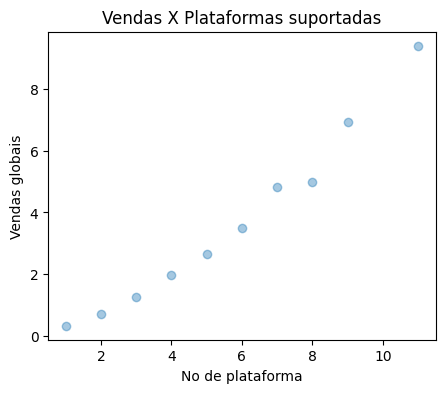

In [11]:

fdf = gdf.copy()
fdf = fdf.groupby("Count_Platforms")["Global_Sales"].mean().reset_index()


plt.figure(figsize=(5, 4))
plt.scatter( 
  fdf['Count_Platforms'],
  fdf['Global_Sales'],

  cmap='viridis',
  alpha=.4
)

plt.ylabel('Vendas globais')
plt.xlabel('No de plataforma')

plt.title('Vendas X Plataformas suportadas')

plt.show()

/tmp/ipykernel_93196/928837984.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(


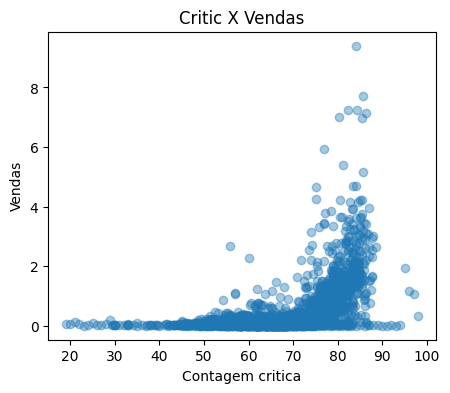

In [12]:

fdf = gdf

min_sales = fdf.groupby('True_Score')['Global_Sales'].min().reset_index()

plt.figure(figsize=(5, 4))
plt.scatter( 
  min_sales['True_Score'],
  min_sales['Global_Sales'],

  cmap='viridis',
  alpha=.4
)

plt.ylabel('Vendas')
plt.xlabel('Contagem critica')

plt.title('Critic X Vendas')

plt.show()

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor

In [20]:
target = 'Global_Sales'

numericos = [ 
    "Count_Platforms",
    'True_Score',
    'Critic_Count',
    "Platform_Codes",
]  

categoricos = [
    'Genre',
    'Year_of_Release',
    'Publisher',
    'Developer',
    'Rating',
]  

norm = lambda col: (col - col.min()) / ( col.max() - col.min() ) 

to_norm = [
    "Platform_Codes",
    "Critic_Count",
    "True_Score",
]

for col in to_norm:
    fdf[col] = norm(fdf[col])

fdf = gdf.copy()

fdf[categoricos] = fdf[categoricos].fillna('NA')  

X = fdf[numericos + categoricos]
y = fdf[ target ]  
y = np.log1p(y)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)

poly = PolynomialFeatures(
    degree=2,
    include_bias=False,
    interaction_only=True
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', poly, numericos),
        # ('num', "passthrough" , numericos),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categoricos)
    ])

gdboost = GradientBoostingRegressor(
    random_state=0,
    learning_rate=0.05,
    max_depth=8,
    n_estimators=800,
    min_samples_split=15,
    min_samples_leaf=10 
)

# rforest = RandomForestRegressor( 
    # random_state=42,
    # max_depth=9,
    # n_estimators=800
# )

model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('regressor', gdboost )
                                #  ('regressor', rforest)
                                #  ('regressor', LinearRegression())
                                #  ('regressor', Ridge())
                                ])


In [22]:
model_pipeline.fit(X_train, y_train)
y_pred= model_pipeline.predict(X_test)

/home/wolke/Documents/datascience/topicos-4/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [23]:
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MSE:", round(mse, 4))
print("R² :", round(r2, 4))


MSE: 0.0491
R² : 0.6833


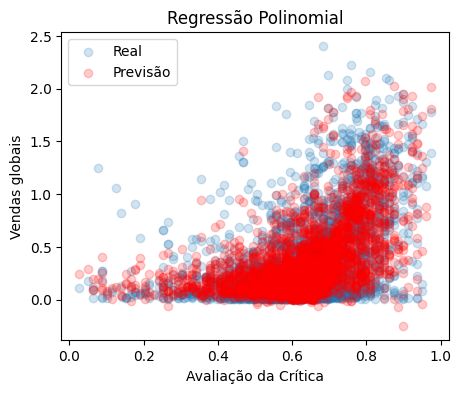

In [24]:
plt.figure(figsize=(5, 4))
plt.scatter(X_test['True_Score'], y_test, alpha=0.2, label='Real')

plt.scatter(X_test["True_Score"], y_pred, color='red', alpha=0.2, label='Previsão')

plt.xlabel('Avaliação da Crítica')
plt.ylabel('Vendas globais')
plt.title('Regressão Polinomial')
plt.legend()
plt.show()

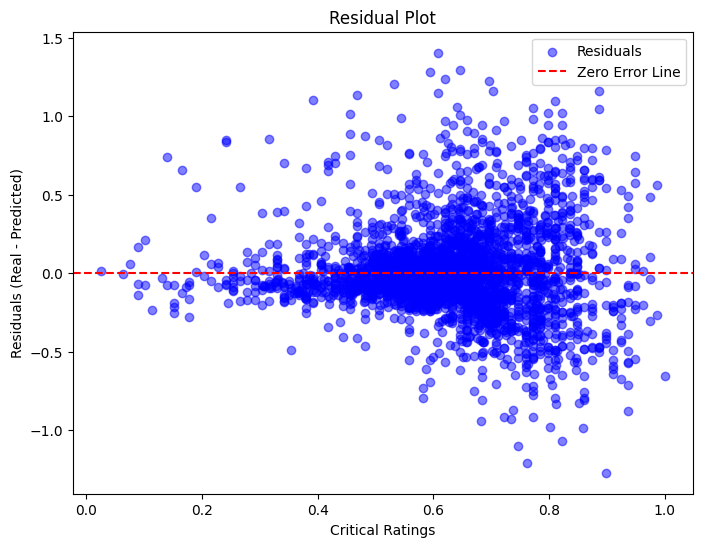

In [19]:
y_pred = model_pipeline.predict(X_test)

residuals = y_test - y_pred

x_axis_values = X_test['True_Score'] 

plt.figure(figsize=(8, 6))
plt.scatter(x_axis_values, residuals, alpha=0.5, color='blue', label='Residuals')
plt.axhline(y=0, color='red', linestyle='--', label='Zero Error Line')

plt.title('Residual Plot')
plt.xlabel('Critical Ratings')
plt.ylabel('Residuals (Real - Predicted)')
plt.legend()
plt.show()
